# Analysis of sensitivity to input range shifts (translations)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import torch

In [4]:
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
import logging, sys
logging.basicConfig(
    level=logging.INFO,
    stream=sys.stdout,
    format="[%(asctime)s] {%(pathname)s:%(lineno)d} %(levelname)s - %(message)s",
    force=True,
)

In [6]:
import sys
sys.path.append("../")

In [7]:
# Import:

import import_export
import examples
import grids
from bnn import SingleHiddenLayerWide1DRegressionNNWithGaussianPriors

import losses

# Analyse a pretrained prior

### Configuration

In [8]:
# ## Activation=NN(ReLU): trained on fixed input range [-3, 3]

# path = "../pretrained/train_priors_and_activations_Ann_1_5_Pgaussian_0s_S1_results.json"
# input_n_dims = 1
# config_set_no = -11

# generator_width = net_width = 1000
# batch_size = 512
# n_nodes = 512

In [9]:
# Activation=NN(Periodic); trained on [-3, 3] but robust in long range

path = "../pretrained/train_fourier2_s2_results.json" 

input_n_dims = 1
config_set_no = -11

generator_width = net_width = 128
batch_size = 512
n_nodes = 512

### Load target (ground truth GP)

In [10]:
(generator, meta, data_min_x, data_max_x,) = examples.get_configs(
        config_set_no=config_set_no, net_width=generator_width
    )

In [11]:
# For evaluation
loss_func = losses.wasserstein_distance

### Load priors


In [12]:
results = import_export.load_from_json(path, target_net_width=net_width)
params = results["parameters"]
activation = params["activation"]

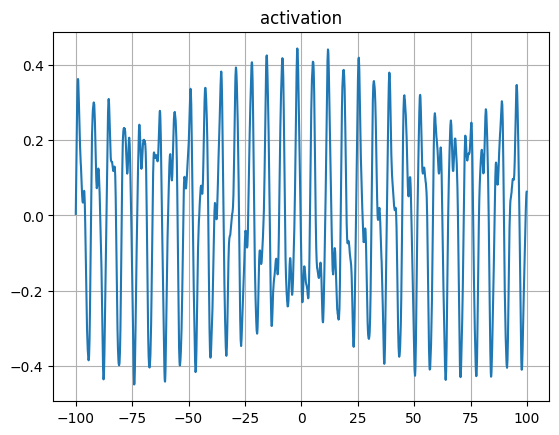

In [13]:
x = torch.arange(-100, 100, 0.1)
plt.plot(x.detach().numpy(), activation(x).detach().numpy())
plt.title("activation");
plt.grid(True)

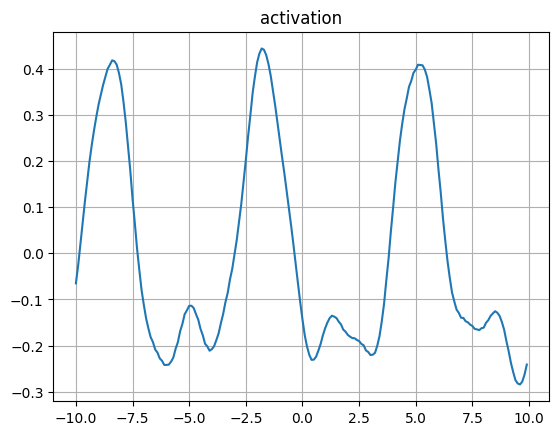

In [14]:
x = torch.arange(-10, 10, 0.1)
plt.plot(x.detach().numpy(), activation(x).detach().numpy())
plt.title("activation");
plt.grid(True)

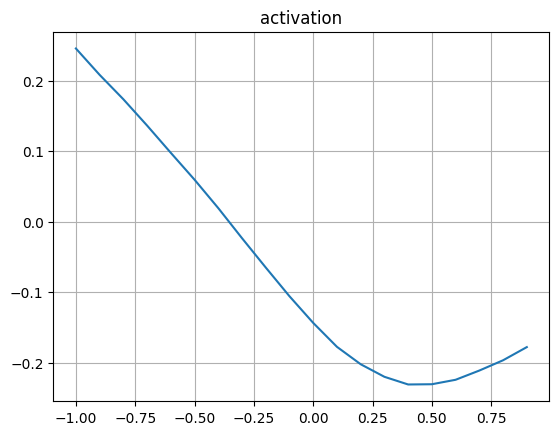

In [15]:
x = torch.arange(-1, 1, 0.1)
plt.plot(x.detach().numpy(), activation(x).detach().numpy())
plt.title("activation");
plt.grid(True)

In [16]:
params

{'layer1.weight': Normal(loc: 0.0, scale: 1.1053650379180908),
 'layer1.bias': Normal(loc: 0.0, scale: 1.4242095947265625),
 'layer2.weight': Normal(loc: 0.0, scale: 0.3851039707660675),
 'layer2.bias': Normal(loc: 0.0, scale: 0.20008550584316254),
 'activation': PeriodicNN(
   (fc1): Linear(in_features=1, out_features=10, bias=True)
   (fc2): Linear(in_features=10, out_features=1, bias=True)
 )}

In [17]:
# print("Loading net from json")
# bnn = results["net_pickle"]

print("Creating a new net based on loaded params")
bnn = SingleHiddenLayerWide1DRegressionNNWithGaussianPriors(parameters=params, likelihood_scale=1e-6, net_width=net_width, in_dim=input_n_dims)

Creating a new net based on loaded params
[2024-10-17 16:33:10,353] {../bnn/bnn_regression_pyro.py:18} INFO - [SingleHiddenLayerWide1DRegressionNNWithGaussianPriors] Using priors parameters = {'layer1.weight': Normal(loc: 0.0, scale: 1.1053650379180908), 'layer1.bias': Normal(loc: 0.0, scale: 1.4242095947265625), 'layer2.weight': Normal(loc: 0.0, scale: 0.3851039707660675), 'layer2.bias': Normal(loc: 0.0, scale: 0.20008550584316254), 'activation': PeriodicNN(
  (fc1): Linear(in_features=1, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)}.


### Evaluation on samples

In [18]:
def eval(data_min_x, data_max_x, n_samples=batch_size):
    sampled_grid = grids.create_sampled_uniform_grid(
                                        data_min_x,
                                        data_max_x,
                                        n_nodes,
                                        n_dims=input_n_dims,
                                        )
    # print("sampled_grid.shape=", sampled_grid.shape)

    bnn_samples = torch.stack([bnn(sampled_grid) for _ in range(n_samples)])
    generator_samples = generator(sampled_grid, n_samples=n_samples).T
    # print(f"bnn_samples.shape={bnn_samples.shape} generator_samples={generator_samples.shape}")

    loss = loss_func(generator_samples, bnn_samples).item()
    return sampled_grid, bnn_samples, generator_samples, loss

sampled_grid, bnn_samples, generator_samples, loss = eval(data_min_x, data_max_x)
print(f"loss = {loss:.4f}")

loss = 0.0143


#### Variance of loss

In [19]:
losses = []
for _ in range(5):
    sampled_grid, bnn_samples, generator_samples, loss = eval(data_min_x, data_max_x)
    losses.append(loss)
std_loss = np.std(losses)   
mean_loss = np.mean(losses) 
print(f"mean_loss={mean_loss:.4f} std_loss={std_loss:.4f}")

mean_loss=0.0124 std_loss=0.0065


#### Domain shift

In [20]:
losses = []
# shifts = np.arange(0, 20, 4)
shifts = [-80, -40, -20, -10, -8, -4, 0, 4, 8, 10, 20, 40, 80]
for i, shift in enumerate(shifts):
    sampled_grid, bnn_samples, generator_samples, loss = eval(data_min_x+shift, data_max_x+shift)
    print(f"{i+1} / {len(shifts)}: shift={shift} => range: [{data_min_x+shift}, {data_max_x+shift}] => loss={loss:.4f}")        
    losses.append(loss)

1 / 13: shift=-80 => range: [-83.0, -77.0] => loss=0.0128
2 / 13: shift=-40 => range: [-43.0, -37.0] => loss=0.0095
3 / 13: shift=-20 => range: [-23.0, -17.0] => loss=0.0093
4 / 13: shift=-10 => range: [-13.0, -7.0] => loss=0.0159
5 / 13: shift=-8 => range: [-11.0, -5.0] => loss=0.0084
6 / 13: shift=-4 => range: [-7.0, -1.0] => loss=0.0092
7 / 13: shift=0 => range: [-3.0, 3.0] => loss=0.0086
8 / 13: shift=4 => range: [1.0, 7.0] => loss=0.0119
9 / 13: shift=8 => range: [5.0, 11.0] => loss=0.0062
10 / 13: shift=10 => range: [7.0, 13.0] => loss=0.0149
11 / 13: shift=20 => range: [17.0, 23.0] => loss=0.0129
12 / 13: shift=40 => range: [37.0, 43.0] => loss=0.0077
13 / 13: shift=80 => range: [77.0, 83.0] => loss=0.0104


### Export plots

In [21]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
fontsize = 14

[2024-10-17 16:34:24,103] {python/lib/python3.8/site-packages/matplotlib/font_manager.py:1350} WARNING - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
[2024-10-17 16:34:24,117] {python/lib/python3.8/site-packages/matplotlib/font_manager.py:1350} WARNING - findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


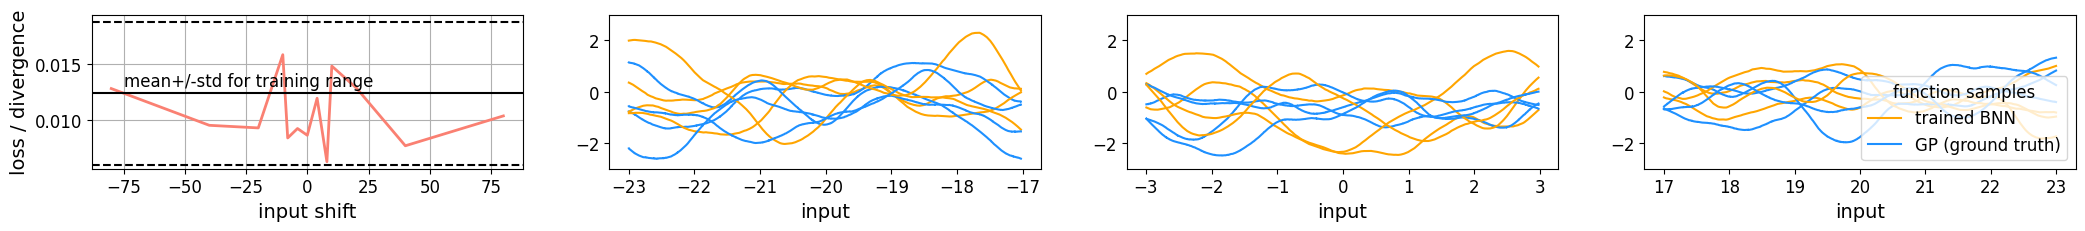

In [22]:
n_samples = 4
fig = plt.figure(figsize=(6.4*4, 2.0))
axes = fig.subplots(nrows=1, ncols=4).flat

plt.sca(axes[0])
plt.plot(shifts, losses, color="salmon", lw=2)
plt.axhline(mean_loss, color="k")
plt.axhline(mean_loss+std_loss, color="k", ls="--")
plt.axhline(mean_loss-std_loss, color="k", ls="--")
plt.text(-75, mean_loss*1.05, "mean+/-std for training range")
plt.xlabel('input shift', fontsize=fontsize)
plt.ylabel("loss / divergence",fontsize=fontsize)
# plt.title(f"Prior quality for BNN trained on range: ({data_min_x}, {data_max_x}) (in={input_n_dims}D)")
plt.grid(True)
# plt.yscale('log')

for i, shift in enumerate([-20, 0, 20]):
    sampled_grid, bnn_samples, generator_samples, loss = eval(data_min_x+shift, data_max_x+shift, n_samples=n_samples)

    plt.sca(axes[i+1])
    if sampled_grid.shape[-1]==1:

        for j in range(n_samples):
            plt.plot(sampled_grid[:,0], bnn_samples[j].T, color="orange", label="trained BNN")
            plt.plot(sampled_grid[:,0], generator_samples[j].T, color="dodgerblue", label="GP (ground truth)")
            plt.xlabel('input', fontsize=fontsize)
            plt.ylim(-3, 3)
            if i==2 and j==0: 
                plt.legend(title="function samples", loc=4)
            

plt.savefig("experiments_shift_sensitivity_analysis.pdf",  bbox_inches='tight')#, pad_inches=0.5)